In [2]:
# Cell 1: Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
from torchvision import transforms, models
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm

In [3]:
# Cell 2: Constants and Directory Creation
DATA_DIR = "data/Specific_test_2"
MODEL_SAVE_PATH = "models/lens_finder_model.pth"
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the 'models' directory if it doesn't exist
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

In [4]:
print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
# Cell 5: Dataset Class and Data Loaders
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from PIL import Image
from torchvision import transforms

class LensDataset(Dataset):
    """
    A custom dataset for loading lens and non-lens images.

    Args:
        class_dir (str): Path to the directory containing images for a single class
                         (e.g., /home/w2sg-arnav/gravitational_lens/data/Specific_test_2/train_nonlenses).
        transform (callable, optional): Optional transform to be applied.
    """
    def __init__(self, class_dir, transform=None):
        self.class_dir = class_dir
        self.transform = transform
        self.classes = ["nonlenses", "lenses"]  # Keep for consistency, error handling
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.samples = self._make_dataset()
        self.error_counts = {"nonlenses": 0, "lenses": 0}  # Initialize for both

    def _make_dataset(self):
        """Creates a list of (image_path, class_index) tuples."""
        samples = []

        print(f"DEBUG: Attempting to use directory: {self.class_dir}")

        if not os.path.isdir(self.class_dir):
            print(f"Directory not found: {self.class_dir}")
            return []  # Return empty list if directory not found

        filenames = [f for f in os.listdir(self.class_dir) if f.endswith(".npy")]
        if not filenames:
            print(f"Warning: Directory {self.class_dir} is empty or contains no .npy files.")
            return [] # Return empty list if no files

        # Determine the class label from the directory name
        class_name = os.path.basename(self.class_dir).replace("train_", "").replace("test_", "")
        label = self.class_to_idx.get(class_name) # Get the label, handle errors

        if label is None:
            print(f"Warning: Unknown class directory name: {self.class_dir}")
            return []

        for filename in filenames:
            path = os.path.join(self.class_dir, filename)
            item = (path, label)
            samples.append(item)
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image_np = np.load(img_path)

            # Normalize *EACH CHANNEL* individually:
            image_np = image_np.astype(np.float32)
            for i in range(image_np.shape[0]):
                channel = image_np[i]
                min_val = channel.min()
                max_val = channel.max()
                if max_val > min_val:
                    image_np[i] = (channel - min_val) / (max_val - min_val)
                else:
                    image_np[i] = 0

            image_np = (image_np * 255).astype(np.uint8)
            image_pil = Image.fromarray(image_np.transpose(1, 2, 0), mode='RGB')

            if self.transform:
                image = self.transform(image_pil)
            else:
                image = transforms.ToTensor()(image_pil)
            return image, label

        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Increment error count based on the class of the image
            class_name = os.path.basename(self.class_dir).replace("train_", "").replace("test_", "")
            if class_name in self.error_counts:  # Check if class_name is valid
                self.error_counts[class_name] += 1
            return torch.zeros((3, 224, 224), dtype=torch.float32), label

    def report_errors(self):
        print("Data loading errors:")
        for cls_name, count in self.error_counts.items():
            print(f"  {cls_name}: {count}")


def create_dataloaders(data_dir, train_transforms, val_transforms, test_transforms, batch_size=32):
    """
    Creates data loaders for training, validation, and test sets.

    Args:
        data_dir (str): Path to the main data directory (e.g., /home/w2sg-arnav/gravitational_lens/data/Specific_test_2).
        train_transforms (callable): Transformations for the training set.
        val_transforms (callable): Transformations for the validation set.
        test_transforms (callable): Transformations for the test set.
        batch_size (int): Batch size.

    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    # Create Datasets (Train and Test) - Now create for EACH class directory, directly under data_dir
    train_lenses_dataset = LensDataset(class_dir=os.path.join(data_dir, "train_lenses"), transform=train_transforms)
    train_nonlenses_dataset = LensDataset(class_dir=os.path.join(data_dir, "train_nonlenses"), transform=train_transforms)
    test_lenses_dataset = LensDataset(class_dir=os.path.join(data_dir, "test_lenses"), transform=test_transforms)
    test_nonlenses_dataset = LensDataset(class_dir=os.path.join(data_dir, "test_nonlenses"), transform=test_transforms)

    # Combine datasets
    train_dataset = torch.utils.data.ConcatDataset([train_lenses_dataset, train_nonlenses_dataset])
    test_dataset = torch.utils.data.ConcatDataset([test_lenses_dataset, test_nonlenses_dataset])

    # Split into train and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # --- Debugging Prints ---
    print(f"Length of train_dataset: {len(train_dataset)}")
    print(f"Length of val_dataset: {len(val_dataset)}")
    print(f"Length of test_dataset: {0 if test_dataset is None else len(test_dataset)}")

    print("First 50 labels of train_dataset:", [train_dataset[i][1] for i in range(min(50, len(train_dataset)))])
    print("First 50 labels of val_dataset:", [val_dataset[i][1] for i in range(min(50, len(val_dataset)))])
    print("First 50 labels of test_dataset:", [test_dataset[i][1] for i in range(min(50,len(test_dataset)))])
    # --- End Debugging Prints ---

    # --- Handle Class Imbalance (WeightedRandomSampler) ---
    class_counts = [0, 0]
    for _, label in train_dataset:
        class_counts[label] += 1
    print(f"Class counts in training set: {class_counts}")

    if class_counts[0] == 0 or class_counts[1] == 0:
        raise ValueError(
            "One or more classes have no samples in the *training* set after splitting. Check your data and split ratio."
        )

    weights = [1.0 / max(1, count) for count in class_counts]  # Avoid division by zero
    sample_weights = [weights[label] for _, label in train_dataset]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = None
    if test_dataset is not None:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

In [9]:
# Cell 6: Model, Loss, Optimizer, Training Loop
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm.notebook import tqdm  # Corrected import
from sklearn.metrics import roc_auc_score

# Set correct absolute path for data directory
DATA_DIR = "/home/w2sg-arnav/gravitational_lens/data/Specific_test_2"

# Constants (make sure these are defined in your notebook)
BATCH_SIZE = 32
LEARNING_RATE = 0.001  # Using a slightly larger learning rate, typical for ResNet
NUM_EPOCHS = 20  # Keeping it at 20 for now, you can increase later
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_PATH = "best_lens_classifier.pth"  # corrected save path


# --- Data Loaders ---
# This MUST be before train_model()
train_loader, val_loader, test_loader = create_dataloaders(
    DATA_DIR, train_transforms, val_transforms, test_transforms, BATCH_SIZE
)

# --- Model Definition (Choose one: Simple CNN or ResNet18) ---

# Option 1: Simple CNN (for debugging/baseline) - NOW COMMENTED OUT
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.model = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(16, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Flatten(),
#             nn.Linear(32 * 56 * 56, 128),  # 224 / 2 / 2 = 56
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, 1)
#         )

#     def forward(self, x):
#         return self.model(x)

# Option 2: ResNet18 (pre-trained) - Now UNCOMMENTED and used
class ResNet18(nn.Module):  # Corrected indentation
    def __init__(self):   # Corrected indentation
        super(ResNet18, self).__init__()  # Corrected indentation
        self.model = models.resnet18(pretrained=True)   # Corrected indentation
        num_ftrs = self.model.fc.in_features  # Corrected indentation
        self.model.fc = nn.Linear(num_ftrs, 1)  # Binary classification  # Corrected indentation

    def forward(self, x):  # Corrected indentation
        return self.model(x)   # Corrected indentation


# --- Choose your model here ---
model = ResNet18().to(DEVICE)  # Now using ResNet18


# --- Loss Function and Optimizer ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# --- Training Loop ---
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device):
    """Trains the model and saves the best weights based on validation AUC."""
    best_val_auc = 0.0
    train_losses = []
    val_losses = []
    train_auc_scores = []
    val_auc_scores = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []

        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            labels = labels.unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            all_labels.extend(labels.cpu().numpy())
            preds = torch.sigmoid(outputs).detach().cpu().numpy()  # Sigmoid for AUC
            all_preds.extend(preds)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_auc = roc_auc_score(all_labels, all_preds)
        print(f'  Train Loss: {epoch_loss:.4f}  Train AUC: {train_auc:.4f}')
        train_losses.append(epoch_loss)
        train_auc_scores.append(train_auc)

        # --- Validation Phase ---
        model.eval()
        running_loss = 0.0
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device).float()
                labels = labels.unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                all_labels.extend(labels.cpu().numpy())
                preds = torch.sigmoid(outputs).detach().cpu().numpy()  # Sigmoid for AUC
                all_preds.extend(preds)

        epoch_loss = running_loss / len(val_loader.dataset)
        val_auc = roc_auc_score(all_labels, all_preds)
        print(f'  Val Loss: {epoch_loss:.4f}    Val AUC: {val_auc:.4f}')
        val_losses.append(epoch_loss)
        val_auc_scores.append(val_auc)

        scheduler.step(epoch_loss)

        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f'  Best model saved at epoch {epoch+1}')

    return train_losses, val_losses, train_auc_scores, val_auc_scores

# --- Train the Model ---
# This is now in the CORRECT place, AFTER create_dataloaders
train_losses, val_losses, train_auc_scores, val_auc_scores = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, NUM_EPOCHS, DEVICE
)

DEBUG: Attempting to use directory: /home/w2sg-arnav/gravitational_lens/data/Specific_test_2/train_lenses
DEBUG: Attempting to use directory: /home/w2sg-arnav/gravitational_lens/data/Specific_test_2/train_nonlenses
DEBUG: Attempting to use directory: /home/w2sg-arnav/gravitational_lens/data/Specific_test_2/test_lenses
DEBUG: Attempting to use directory: /home/w2sg-arnav/gravitational_lens/data/Specific_test_2/test_nonlenses
Length of train_dataset: 24324
Length of val_dataset: 6081
Length of test_dataset: 19650
First 50 labels of train_dataset: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
First 50 labels of val_dataset: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
First 50 labels of test_dataset: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

/home/w2sg-arnav/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/w2sg-arnav/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.2247  Train AUC: 0.9685


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.4206    Val AUC: 0.9803
  Best model saved at epoch 1
Epoch 2/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.1687  Train AUC: 0.9816


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.1945    Val AUC: 0.9842
  Best model saved at epoch 2
Epoch 3/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.1411  Train AUC: 0.9865


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.1122    Val AUC: 0.9876
  Best model saved at epoch 3
Epoch 4/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.1273  Train AUC: 0.9885


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.1098    Val AUC: 0.9865
Epoch 5/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.1129  Train AUC: 0.9911


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.1519    Val AUC: 0.9861
Epoch 6/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.0952  Train AUC: 0.9936


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.1179    Val AUC: 0.9882
  Best model saved at epoch 6
Epoch 7/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.0888  Train AUC: 0.9938


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.0922    Val AUC: 0.9895
  Best model saved at epoch 7
Epoch 8/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.0840  Train AUC: 0.9946


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.0718    Val AUC: 0.9900
  Best model saved at epoch 8
Epoch 9/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.0748  Train AUC: 0.9955


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.0747    Val AUC: 0.9863
Epoch 10/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.0741  Train AUC: 0.9957


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.1065    Val AUC: 0.9889
Epoch 11/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.0604  Train AUC: 0.9968


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.0639    Val AUC: 0.9916
  Best model saved at epoch 11
Epoch 12/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.0580  Train AUC: 0.9968


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.1110    Val AUC: 0.9905
Epoch 13/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.0584  Train AUC: 0.9971


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.0754    Val AUC: 0.9899
Epoch 14/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.0531  Train AUC: 0.9971


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.0970    Val AUC: 0.9904
Epoch 15/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.0497  Train AUC: 0.9977


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.0877    Val AUC: 0.9896
Epoch 16/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.0450  Train AUC: 0.9979


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.0999    Val AUC: 0.9889
Epoch 17/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.0501  Train AUC: 0.9976


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.1005    Val AUC: 0.9918
  Best model saved at epoch 17
Epoch 18/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.0425  Train AUC: 0.9982


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.0797    Val AUC: 0.9859
Epoch 19/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.0410  Train AUC: 0.9981


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.0673    Val AUC: 0.9900
Epoch 20/20


Training:   0%|          | 0/761 [00:00<?, ?it/s]

  Train Loss: 0.0389  Train AUC: 0.9984


Validation:   0%|          | 0/191 [00:00<?, ?it/s]

  Val Loss: 0.0702    Val AUC: 0.9900


In [10]:
def plot_training_history(train_losses, val_losses, train_auc, val_auc):
    """Plots the training and validation loss and AUC over epochs."""
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_auc, 'b-', label='Training AUC')
    plt.plot(epochs, val_auc, 'r-', label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
def plot_roc_curve(labels, probabilities, num_classes):
    """Plots the ROC curve."""
    if num_classes > 1:  # Multiclass (not used in this binary case)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            class_labels = [1 if label == i else 0 for label in labels]
            fpr[i], tpr[i], _ = roc_curve(class_labels, [prob[i] for prob in probabilities])
            roc_auc[i] = auc(fpr[i], tpr[i])
        plt.figure(figsize=(8, 6))
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    else:  # Binary case
        fpr, tpr, _ = roc_curve(labels, probabilities)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


def plot_confusion_matrix(labels, probabilities, classes):
    """Plots the confusion matrix."""
    preds = np.round(probabilities).astype(int)  # Round for binary classification
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

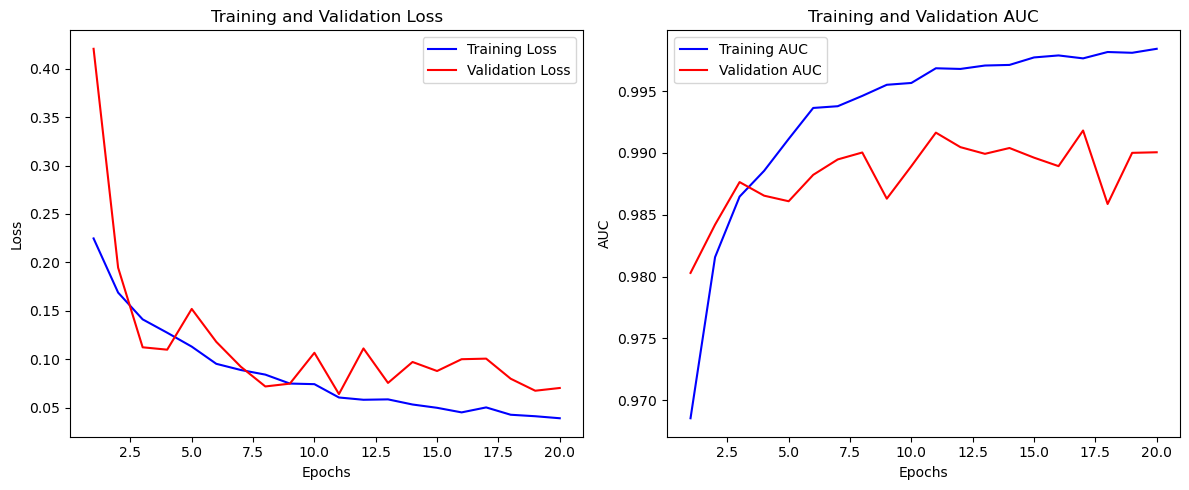

In [12]:
plot_training_history(train_losses, val_losses, train_auc_scores, val_auc_scores)

Evaluating:   0%|          | 0/615 [00:00<?, ?it/s]

Test AUC: 0.9837


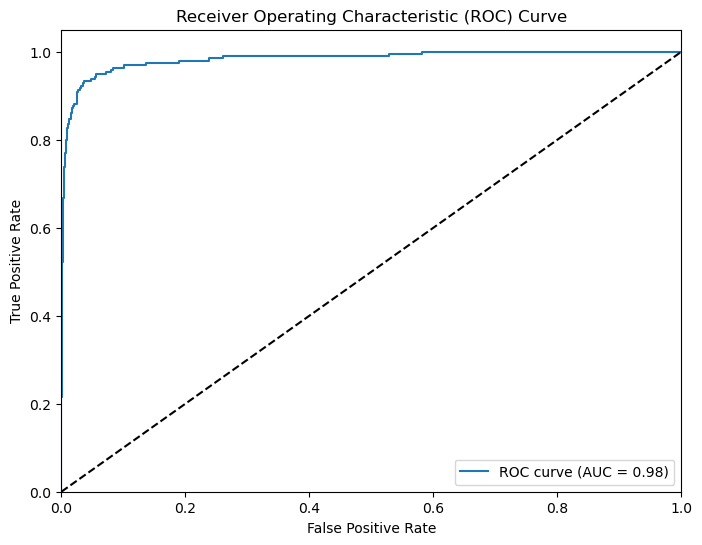

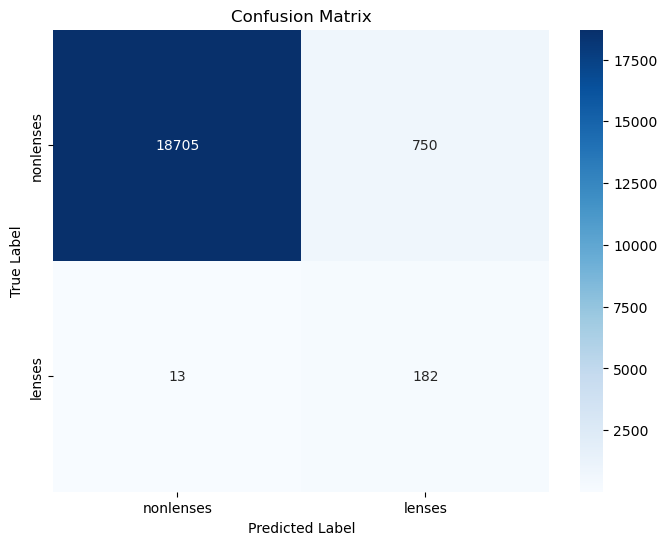

In [13]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

def evaluate_model(model, data_loader, device):
    """Evaluates the model on the given data loader."""
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            labels = labels.unsqueeze(1)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy()  # Sigmoid for probabilities

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

    return all_labels, all_probs

test_labels, test_probs = evaluate_model(model, test_loader, DEVICE)

if len(test_labels) > 0:
    test_auc = roc_auc_score(test_labels, test_probs)
    print(f"Test AUC: {test_auc:.4f}")

    plot_roc_curve(test_labels, test_probs, num_classes=1)
    plot_confusion_matrix(
        test_labels, test_probs, classes=["nonlenses", "lenses"]
    )
else:
    print("Test AUC: N/A (empty test set)")